# **KL DIVERGENCE TO MEASURE DISTANCE BETWEEN CURVES**

In [1]:
import numpy as np
import pandas as pd
from numpy import linalg as la
import random, math
from scipy.stats import norm, uniform, binom
import seaborn as sns
from scipy.stats import norm, entropy
import matplotlib.pyplot as plt

random_seed = 42

### **Data Preperation**

In [2]:
mu1 = 2.0 
mu2 = 9.0 
sd1 = 2.0
sd2 = 2.0

y1 = np.random.normal(mu1, sd1, 1000)
y2 = np.random.normal(mu2, sd2, 5000)
data=np.append(y1,y2)

<Axes: ylabel='Density'>

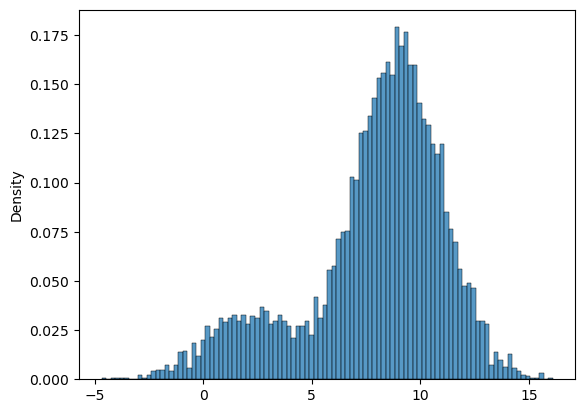

In [24]:
sns.histplot(data, stat='density', bins=100, kde=False)                              # bins -> number of bars to be made, kde -> should a graph be plotted 

###  **INITIALIZATION**

We have our datapoints. Now we assume that these datapoints have come up due to the mixing on 'n' gaussians. 

In [4]:
number_of_gaussians = 2

def gaussian_pdf(X, mu, sd):
    Z = (X - mu) / sd
    var = sd ** 2
    return (1 / np.sqrt(2 * np.pi * var)) * np.exp(-Z ** 2 / 2)

def mean(X):
    return sum(X)/len(X)

def standard_deviation(X):
    m = mean(X)
    return (sum([(x - m) ** 2 for x in X])/len(X)) ** (0.5)

This distribution of datapoints is done according to the formula :
$$
p(x_i) = \sum_{k=1}^{K} \pi_k \, \mathcal{N}(x_i \mid \mu_k, \Sigma_k)
$$
\
**$\pi_k$** : mixing factor, which shows the weight of that gaussian within the weighted sum

**$\mu_k$** : mean of that gaussian

**$\Sigma_k$** : standard deviation of that gaussian\
\
For the implementation, we take a random value for the mu of each gaussian and stddev of each gaussian

**NOTE:** Here, we **cant** use the initialization as I have done below. The reason for the same is that this leads to each of the components getting the same value of mu and stddev.\
This causes the algorithm to find the datapoints **un-classifiable**. So ideally atleast one of 'mus' or 'stddevs' must be randomly initialized.\
\
More mathematically :
1) In the first E-step, every Gaussian will assign nearly **equal responsibility** to each data point.
2) The M-step then recomputes the means — but they **update identically** again due to symmetry in the responsibilities.

In [ ]:
mean_value = mean(data)
stddev_value = standard_deviation(data)

# mus = np.full(number_of_gaussians, mean_value)               # Cant use this due to lack of randomness
# stddevs = np.full(number_of_gaussians, stddev_value)         # Cant use this due to lack of randomness

mus = np.random.choice(data, number_of_gaussians)              # Pick k random data - points from the given data to be initialized as the initial mu (Similar to K - Means)
stddevs = np.full(number_of_gaussians, stddev_value)           # Initialized all values as the stdev of the data, here the mu will be responsible for generating randomness

In [6]:
weights = np.full(number_of_gaussians, 1/number_of_gaussians)  # Now, we initialize the weights for the mixing. Initially each gaussian is given equal weight i.e, 1/n
log_likelihoods = []

### **EM ALGORITHM**

Now, as a part of the EM algorithm we have 4 steps :
1)  **E - Step** : Expectation
2)  **M - Step** : Maximization 
3)  **Convergence Check** : Log - Likelihood

#### **E Step:**
Responsibility $\gamma_{ik}$ represents the probability that that data point $x_i$ belongs to the gaussian $k$. The formula for the same is given by :
$$
\gamma_{ik} = \frac{\pi_k \, \mathcal{N}(x_i \mid \mu_k, \Sigma_k)}{\sum_{j=1}^{K} \pi_j \, \mathcal{N}(x_i \mid \mu_j, \Sigma_j)}
$$
1) In the responsibilities 2D array, a column vector would represent the chance of each datapoint belonging to that gaussian.
2) The for loop fills data column wise. 
3) sum_resp is an array of values of columnwise sums

#### **M Step:**
This is the maximization step in which the parameters are updated. 

**Effective number of points assigned to component** :
$$
N_k = \sum_{i=1}^{n} \gamma_{ik}
$$

**Update mixing coefficient for component** :
$$
\pi_k = \frac{N_k}{n}
$$

**Update mean of component** :
$$
\mu_k = \frac{1}{N_k} \sum_{i=1}^{n} \gamma_{ik} \, x_i
$$

**Update covariance matrix of component** :
$$
\Sigma_k = \frac{1}{N_k} \sum_{i=1}^{n} \gamma_{ik} \, (x_i - \mu_k)(x_i - \mu_k)^T
$$

#### **Log Likelihood Calculation:**

The likelihood of the parameters being the ones that are currently calculated is given by :
$$
L(\pi_k, \mu_k, \Sigma_k) = \prod_{i=1}^{n} \left( \sum_{k=1}^{K} \pi_k \, \mathcal{N}(x_i \mid \mu_k, \Sigma_k) \right)
$$

This can be reduced down to :
$$
\log L(\pi_k, \mu_k, \Sigma_k) = \sum_{i=1}^{n} \log \left( \sum_{k=1}^{K} \pi_k \, \mathcal{N}(x_i \mid \mu_k, \Sigma_k) \right)
$$

Which is easier to compute due to the $\Sigma$ instead of the $\Pi$


In [7]:
def E_Step(X, means, devs, weights):

    resp = np.zeros((len(X), number_of_gaussians))                              # n rows & k columns; (1500 x 2) 
    sum_resp = []

    for i in range(number_of_gaussians):
        resp[:, i] = weights[i] * gaussian_pdf(X, means[i], devs[i])            # pi_k * N(x | mu_k, S_k)

    for i in range(len(X)):
        sum_resp.append(sum(resp[i, :]))

    sum_resp = np.array(sum_resp)
    sum_resp = sum_resp.reshape(-1, 1)
    resp /= sum_resp

    return resp

    
def M_Step(X, R, means, devs, weights):

    N = []
    for i in range(number_of_gaussians):
        N.append(sum(R[:, i]))                                                  # N = number of datapoints belonging to the gaussian
        weights[i] = N[i]/len(X)                                                # Weight updation
        means[i] = sum(R[:, i] * X) / N[i]                                      # Mean updation
        devs[i] = ( sum(R[:, i] * (X - means[i]) ** 2) / N[i] ) ** (0.5)        # Stdev updation

    return weights, means, devs


def Log_Likelihood(X, means, devs, weights):

    likelihood = np.zeros((len(X), number_of_gaussians))
    for i in range(number_of_gaussians):
        likelihood[:, i] = weights[i] * gaussian_pdf(X, means[i], devs[i])

    return (sum(np.log(likelihood.sum(axis=1))))


def EM(X, means, devs, weights, ll):
    for i in range(1000):
        Responsibilities = E_Step(X, means, devs, weights)                             # E - Step which calculates the responsibility

        weights, means, devs = M_Step(X, Responsibilities, means, devs, weights)       # M - Step which optimizes the values of the parameters 

        l = Log_Likelihood(X, means, devs, weights)                                    # LL Computation
        ll.append(l)

        # Convergence Check :
        if (len(ll) > 1) and ( abs(ll[-1] - ll[-2]) < 1e-4 ):                           # If the last two ll values were similar, break the loop as the values have started to converge
            break
    
    return weights, means, devs

In [8]:
weights, means, std_devs = EM(data, mus, stddevs, weights, log_likelihoods)
print(f'Estimated means: {means}')
print(f'Estimated std devs: {std_devs}')
print(f'Estimated weights: {weights}')

Estimated means: [9.0233435  1.98143862]
Estimated std devs: [1.9932729  1.96102398]
Estimated weights: [0.83818442 0.16181558]


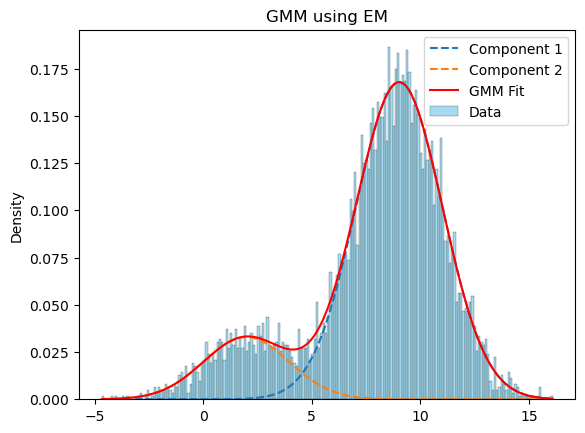

In [37]:
x_vals = np.linspace(min(data), max(data), 1000)
pdf = np.zeros_like(x_vals)

for i in range(number_of_gaussians):
    component_pdf = weights[i] * gaussian_pdf(x_vals, means[i], std_devs[i])
    pdf += component_pdf
    plt.plot(x_vals, component_pdf, '--', label=f'Component {i+1}')

sns.histplot(data, bins=200, stat='density', color='skyblue', label='Data')
plt.plot(x_vals, pdf, 'r', label='GMM Fit')
plt.title('GMM using EM')
plt.legend()
plt.show()


### **KL DIVERGENCE ALGORITHM**

This is an algorithm that can be used to measure the distance between distributions. There are two possible ways to do the same :

1. **Discrete:**   
$$
D_{KL}(P \parallel Q) = \sum_i P(i) \log\left(\frac{P(i)}{Q(i)}\right)
$$

2. **Continuous:**

$$
D_{KL}(P \parallel Q) = \int P(x) \log\left(\frac{P(x)}{Q(x)}\right) \, dx\
$$
\
This is also known as the relative-entropy. It is an alternative to shannon - entropy when the value of Q(x) is not none

In [36]:
hist_counts, bin_edges = np.histogram(data, bins = 2000, density=True)
hist_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

gmm_estimate = np.zeros_like(hist_centers)
for i in range(number_of_gaussians):
    gmm_estimate += weights[i] * gaussian_pdf(hist_centers, means[i], std_devs[i])      # Fit our prediction based on 

hist_counts += 1e-10                                                                   # As P(x) or Q(x) may = 0.0 which would lead to an error, we add small values
gmm_estimate += 1e-10

kl_div = entropy(hist_counts, gmm_estimate)
print(f"KL Divergence between actual distribution and GMM fit: {kl_div:.2f}")
print(f"Hence, the accuracy is {(100 - (kl_div * 100)):.2f}%")

KL Divergence between actual distribution and GMM fit: 0.16
Hence, the accuracy is 83.65%
